# Softmax 연습문제

아래의 노트북 파일의 각 셀에 해당하는 문제의 답을, 외부 파일에 구현해야 하는 코딩까지 포함하여, 도출하시오.

softmax 연습문제와 유사하게 본 연습문제에서 여러분은 다음의 사항을 완수해야 함:

- Softmax loss function을 계산하는 Numpy 기반 완전 벡터화된fully-vectorized 함수를 구현함
- Softmax loss function의 완전 벡터화된 함수에 대응되도록 analytic gradient를 계산하는 완전 벡터화된 함수를 구현함
- numerical gradient를 계산하는 함수를 함께 구현하여, 앞서 구현한 analytic gradient의 유효성 여부를 check함
- Validation set을 이용하여 hyperparameter들, 즉 learning rate 및 regularization strength의 최적값을 도출함
- SGD를 이용하여 구현한 loss function의 최적화함
- 학습 결과로 도출된 weight parameter들을 시각화함

### 셀1: 본 노트북의 환경 설정을 위한 코드

필요한 패키지 임포트, 그래프plot 크기 설정, 영상 config 설정 등 수행하며, 별도의 코딩 없이 수행만 시키면 됨.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

### 셀2: CIFAR-10 Data Loading and Preprocessing

다음 셀에서는 모두 데이터 불러오기 및 전처리 등을 수행하며, 역시 별도의 코딩 없이 수행만 시키면 됨.

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    softmax, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## 셀3-8 Softmax Classifier

다음 셀들은 Multiclass Softmax loss function을 기반으로 하는 linear classification과 관련되며, 여러분이 직접 코드를 구현하여야 함. 이때 모든 코드는 cs231n/classifiers/softmax.py 파일 내에 구현함.

### 셀3: Softmax loss naive 함수 내 Softmax loss 값 계산 및 gradient 계산 코드 구현

**구현 문제 1**:
`cs231n/classifiers/softmax.py` 파일 내 `softmax_loss_naive` 함수 내에 **Softmax loss 함수값을 계산하는 코드를 구현**하시오. 이때 과제2(상)에서 제공되었던 `softmax_loss_naive` 함수 내의 코드와 같이 for 문이 사용되는 nested loop 형식으로 구현하시오.
그리고 아래 셀을 실행하여 구현된 코드를 수행하여 계산된 loss 값을 -log(0.1) 값과 비교하게 벡터 값을 제대로 계산했는지, 유효성을 검증하시오.

In [13]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.381970
sanity check: 2.302585


**서술 문제 1**

왜 loss 값이 -log(0.1) 값과 비슷해야 하는가? 간단하게 설명하시오.**

$\color{blue}{여러분의}$ $\color{blue}{답:}$  
-np.log는 cross entorpy 부분이라 함수안에 들어가는 부분은 softmax의 결과입니다.  
softmax 결과는 마지막 레이어의 데이터를 토대로 확률로 변환시켜 줍니다.  
이때 처음에는 완전 렌덤한값이 들어있는데 이 때 정확도는 1/class 수 이여야 합니다.  
지금은 class가 10 이므로 0.1 되어야 합니다.  


### 셀4: Softmax loss naive 함수 중 gradient 항 계산 코드 구현

**구현 문제 2**: **Softmax SVM loss 함수의 해석적인 gradient 벡터를 직접 계산하여 도출하고, 이를 코드로 구현**하여 `softmax_loss_naive` 함수를 완성하시오.

구현된 코드가 gradient 벡터 값을 제대로 계산했는지, 유효성을 검증하기 위해, 강의동영상에서 설명한 바와 같이 gradient를 수치적numerically으로도 근사하여 계산할 수 있음. 이를 수행하는 코드는 제공되는 코드의 `cs231n/gradient_check` 파일에 포함되어 있으며, 아래 셀에서는 이를 활용하도록 구현이 되어 있음.

In [4]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.|
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -2.612676 analytic: -2.612676, relative error: 3.497505e-09
numerical: 0.339523 analytic: 0.339523, relative error: 3.013319e-08
numerical: -2.504756 analytic: -2.504756, relative error: 8.415201e-09
numerical: -2.380922 analytic: -2.380922, relative error: 2.772948e-09
numerical: 3.128294 analytic: 3.128294, relative error: 4.011732e-10
numerical: 1.635355 analytic: 1.635355, relative error: 1.876730e-08
numerical: 2.670127 analytic: 2.670127, relative error: 4.182797e-09
numerical: 2.912883 analytic: 2.912883, relative error: 1.154224e-08
numerical: 0.294196 analytic: 0.294196, relative error: 6.556277e-08
numerical: -4.846335 analytic: -4.846335, relative error: 2.414492e-09
numerical: 1.759656 analytic: 1.759656, relative error: 1.291871e-08
numerical: -3.015085 analytic: -3.015085, relative error: 6.436963e-09
numerical: 1.486285 analytic: 1.486285, relative error: 3.131785e-08
numerical: 0.415255 analytic: 0.415255, relative error: 2.935235e-08
numerical: -0.735900 ana

### 셀5: Softmax 함수의 loss 및 gradient를 계산하는 vectorized 코드 구현

**구현 문제 3**: 아래 셀에서 호출되는 **함수 `svm_loss_vectorized`의 내부 중 loss 값 및 gradient 벡터를 계산하는 부분을 구현하시오**. 

이때 Data 변수들이 Numpy의 패키지의 ndarray이기 때문에, Numpy 패키지에 내장된 vectorization 방식의 고속 연산 기능을 활용할 수 있음. 참고로 vectorization 기능을 적절하게 활용할 경우 `softmax_loss_naive`에 있었던 for문 loop는 필요가 없어지며, 계산 결과는 `softmax_loss_naive`와 동일하게 도출되지만 수행속도는 월등하게 빨라짐.

In [5]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.295943e+00 computed in 0.133342s
vectorized loss: 2.295943e+00 computed in 0.002645s
Loss difference: 0.000000
Gradient difference: 0.000000


### 셀 6: Hyperparameter tuning

**구현 문제 4**: 앞서 분할해 놓은 validation dataset을 이용하여 아래 셀에 Softmax loss를 기반으로 모델을 학습하면서, learning rate 및 regularization 가중치 등 hyperparameter를 최적화하는 코드를 구현하시오. 

지난 과제의 셀 11에서는 파일 `cs231n/classifiers/linear_classifier.py` 내에 정의된 LinearClassifier class의 두 가지 하위 클래스 중 LinearSVM 클래스의 객체를 생성하여, 여러분이 구현한 LinearClassifier.train() 함수를 호출하도록 하였음.
이번 과제에서는 LinearClassifier class의 두 가지 하위 클래스 중 Softmax 클래스의 객체를 정의하고, 이를 기반으로 모델을 학습하는 과정을 활용함.

더 상세한 내용은 아래 코드의 주석을 확인하시오.

In [6]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.

from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]
iters = 1000
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
for i in range(len(learning_rates)):
    for j in range(len(regularization_strengths)):
        #train
        softmax = Softmax()
        softmax.train(X_train, y_train, learning_rate=learning_rates[i], reg=regularization_strengths[j],num_iters=iters, verbose=False)
        y_train_pred = softmax.predict(X_train)
        y_val_pred = softmax.predict(X_val)
        training_accuracy = np.mean(y_train == y_train_pred)
        validation_accuracy = np.mean(y_val == y_val_pred)

        # save data
        results[(learning_rates[i], regularization_strengths[j])] = (training_accuracy, validation_accuracy)

        # if best
        if best_val < validation_accuracy:
            best_val = validation_accuracy
            best_softmax = softmax
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.329347 val accuracy: 0.343000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.302469 val accuracy: 0.320000
lr 5.000000e-07 reg 2.500000e+04 train accuracy: 0.332673 val accuracy: 0.349000
lr 5.000000e-07 reg 5.000000e+04 train accuracy: 0.305510 val accuracy: 0.320000
best validation accuracy achieved during cross-validation: 0.349000


### 셀 7: test set에 대한 Softmax classifier 성능 확인

학습된 softmax loss 기반의 linear classifier의 정확도를 test dataset에 대해서 측정하여 제시함.

In [7]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.352000


**서술 문제 2** - *아래 명제에 대해 참 or 거짓인지를 제시하시오.*

전체 학습 loss는 모든 training example별 loss의 총합으로 정의함. 이때, 새로운 training example을 하나 추가할 때, multiclass SVM loss 값은 추가한 example 데이터의 특성에 따라 총 loss 값이 달라지지 않을수도 있지만, softmax loss에 대해서는 무조건 총 loss 값이 달라짐. 

$\color{blue}{여러분의}$ $\color{blue}{답:}$ 참


$\color{blue}{원인:}$  
결국에 물어보는 것은 추가한 training example이 loss가 0이 될 수 있는가를 물어보는것입니다.

svmloss는 실제 score 값에서 참인 label의 점수가 나머지보다 모두 1보다 커버리게 된다면 그 이미지에 대해서는 0이 되긴합니다. 

하지만 softmax는 cross entropy loss가 0이 되려면, 그이미지가 100퍼센트라고 예측을 해줘야합니다.  
softmax는 A/(A+B) 꼴로 A는 실제 label에 대한 예측값이고 B는 다른 class에 대한 예측들의 합인데,  
대충 계산해보니 2개의 클래스에 대해서 계산을 해볼때 실제 클래스와 각클래스의 내적 결과가 40정도 차이가 나줘야지 컴퓨터 상에서 0이 되는것을 확인할 수 있었습니다.(부동소숫점 오류때문이지 loss는 있습니다. 실제는 이 차이가 무한대가 되야 합니다.)
즉 가능은하나 확률상 example을 조작하는것이 아니면 확률이 정말 낮다고 할 수 있고, class갯수가 많으면 많을수록 더더욱 확률상 말이 안됩니다.
그러므로 loss 값은 무조건 증가한다고 해도 무방합니다.

요약  
svmloss 는 정답클래스랑 다른 클래스랑 내적값 차이가 1만 발생하면된다. -> 가능성이 어느정도 있다  
softmax는 정답클래스랑 다른 클래스랑 내적값 차이가 40이상 발생해야한다. -> 가능성이 거의 없다

In [8]:
soft_max = np.exp(0)/(np.exp(0)+np.exp(-40)+np.exp(-40)+np.exp(-40)+np.exp(-40)+np.exp(-40)+np.exp(-40)+np.exp(-40)+np.exp(-40)+np.exp(-40))
#soft_max = np.exp(0)/(np.exp(0)+np.exp(-30)+np.exp(-40)+np.exp(-40)+np.exp(-40)+np.exp(-40)+np.exp(-40)+np.exp(-40)+np.exp(-40)+np.exp(-40))
print(soft_max)
print(-np.log(soft_max))

1.0
-0.0


### 셀 8: 학습된 class 별 weight parameter 시각화

아래 셀에서는 강의03 강의동영상(슬라이드 36번)에서 설명되었던 linear classifier의 시각적 이해 관점에서, 학습된 softmax loss 기반의 linear classifier의 class별 weight vector를 이미지로 시각화하여 제시함.

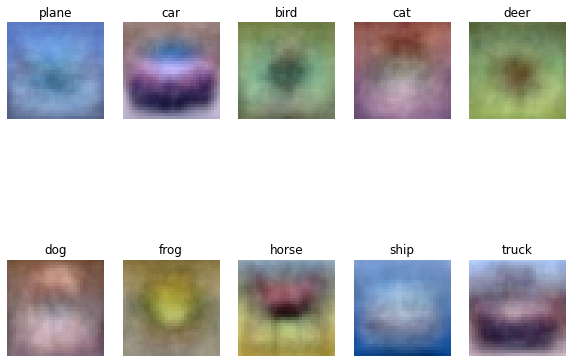

In [14]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])